#### MNIST Fasion 분류


In [36]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision.transforms import *
from torchvision.datasets import FashionMNIST
from torch.utils.data import DataLoader, Dataset
from torch.autograd import Variable

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

In [4]:
train_dataset= FashionMNIST('../data', download=True,
                            transform=transforms.Compose([transforms.ToTensor()]))
test_dataset= FashionMNIST('../data', download=True, train=False,
                           transform=transforms.Compose([transforms.ToTensor()]))

100.0%


Extracting ../data\FashionMNIST\raw\train-images-idx3-ubyte.gz to ../data\FashionMNIST\raw



100.0%


Extracting ../data\FashionMNIST\raw\train-labels-idx1-ubyte.gz to ../data\FashionMNIST\raw



100.0%


Extracting ../data\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to ../data\FashionMNIST\raw



100.0%

Extracting ../data\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to ../data\FashionMNIST\raw



In [6]:
# 전처리 필요 x -> 바로 DL생성
trainDL=DataLoader(train_dataset, batch_size=100)
testDL= DataLoader(test_dataset, batch_size=100)

In [7]:
labels_map= {0:'T-shirt', 1:'Trouser', 2:'Pullover', 3:'Dress',
             4:'Coat', 5:'Sandal', 6:'Shirt', 7:'Sneaker',
             8:'Bag', 9:'Ankle_Boot'  
             }

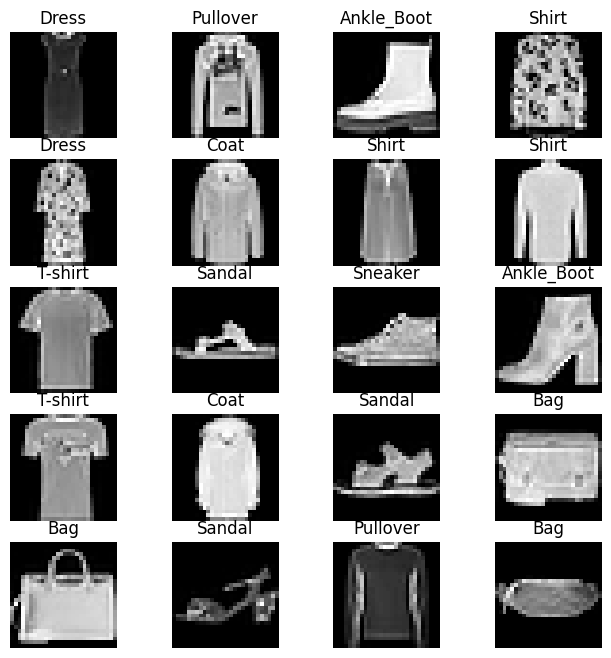

In [18]:
fig= plt.figure(figsize=(8,8))
columns=4; rows=5
for i in range(1, columns*rows+1):
    img_xy= np.random.randint(len(train_dataset))
    img= train_dataset[img_xy][0][0,:,:]
    fig.add_subplot(rows, columns, i)
    plt.title(labels_map[train_dataset[img_xy][1]])
    plt.axis('off')
    plt.imshow(img, cmap='gray')
plt.show()


In [31]:
# 모델 클래스 생성
class FashionCNN(nn.Module):
    def __init__(self) -> None:
        # super().__init__(FashionCNN, self).__init__()
        super().__init__()
        self.layer1= nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.layer2= nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.fc1=nn.Linear(in_features=64*6*6, out_features=600)
        self.drop=nn.Dropout2d(0.25)
        self.fc2=nn.Linear(in_features=600, out_features=120)
        self.fc3=nn.Linear(in_features=120, out_features=10)

    def forward(self, x):
        out=self.layer1(x)
        out=self.layer2(out)
        out=out.view(out.size(0), -1) #데이터 1차원으로 변경
        out=self.fc1(out)
        out=self.drop(out)
        out=self.fc2(out)
        out=self.fc3(out)
        return out

In [33]:
# 파라미터 선언
LR=0.001
model=FashionCNN()
DEVICE= 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(DEVICE)
criterion= nn.CrossEntropyLoss()
optimizer=optim.Adam(model.parameters(), lr=LR)
model.parameters

<bound method Module.parameters of FashionCNN(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=2304, out_features=600, bias=True)
  (drop): Dropout2d(p=0.25, inplace=False)
  (fc2): Linear(in_features=600, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=10, bias=True)
)>

In [34]:
EPOCH=5
cnt=0
loss_list, iteration_list, accuaracy_list= [],[],[]
predictions_list, labels_list=[],[]

In [39]:
for ep in range(EPOCH):
    for images, labels in trainDL:
        images, labels= images.to(DEVICE), labels.to(DEVICE)

        train=Variable(images.view(100,1,28,28))
        labels=Variable(labels)

        outputs= model(train)
        loss= criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        cnt+=1
        if ~(cnt%50):
            total, correct=0,0
            for images, labels in testDL:
                images, labels= images.to(DEVICE), labels.to(DEVICE)
                labels_list.append(labels)
                test=Variable(images.view(100,1,28,28))
                outputs=model(test)
                predictions=torch.max(outputs, 1)[1].to(DEVICE)
                predictions_list.append(predictions)
                correct+=(predictions==labels).sum()
                total+=len(labels)
            
            accuaracy=correct*100/total
            loss_list.append(loss.data)
            iteration_list.append(cnt)
            accuaracy_list.append(accuaracy)
        if ~(cnt%500):
            print(f'Iteration: {cnt}, Loss: {loss.data}, Accuracy: {accuaracy}%')


Iteration: 11, Loss: 0.6486784219741821, Accuracy: 66.02999877929688%
Iteration: 12, Loss: 0.737751305103302, Accuracy: 67.05000305175781%
Iteration: 13, Loss: 1.0450714826583862, Accuracy: 71.5%
Iteration: 14, Loss: 0.8012471199035645, Accuracy: 73.69999694824219%
Iteration: 15, Loss: 0.5612179636955261, Accuracy: 72.38999938964844%
Iteration: 16, Loss: 0.726372480392456, Accuracy: 70.69000244140625%
Iteration: 17, Loss: 0.728300929069519, Accuracy: 68.04000091552734%
Iteration: 18, Loss: 0.8024224638938904, Accuracy: 70.81999969482422%
Iteration: 19, Loss: 0.5458683967590332, Accuracy: 75.58000183105469%
Iteration: 20, Loss: 0.6572539806365967, Accuracy: 75.22000122070312%
Iteration: 21, Loss: 0.6256283521652222, Accuracy: 72.45999908447266%
Iteration: 22, Loss: 0.8875340819358826, Accuracy: 72.01000213623047%
Iteration: 23, Loss: 0.7923738360404968, Accuracy: 68.37000274658203%
Iteration: 24, Loss: 0.9164769649505615, Accuracy: 73.80000305175781%
Iteration: 25, Loss: 0.8699792623519

KeyboardInterrupt: 